Importing Essential Libraries for the Project

In [5]:
import numpy as np
import matplotlib.pyplot as plt

1.1 (Q1) - GENERATE A RECTANGULAR GRID

In [6]:
def interior_grid_generation(Nx, Ny):
    """
    Here I m creating a interior grid for [0,1]x[0,1], excluding boundary.
    -> Nx, Ny: Total number of subdivisions in x and y directions.
    -> dx & dy: Grid spacing along x and y..
    If Nx =4, then dx = 1/4 = 0.25, means np.linspace(0.25, 0.75, 3)= [0.25, 0.5, 0.75]
    so here we are excluding boundary points 0 and 1.
    
    Returns:
      x_vals, y_vals: 1D arrays of interior coordinates
      dx & dy: Grid spacing along x and y.
    """
    dx = 1.0 / Nx                                           
    dy = 1.0 / Ny
    # Interior points only: i=1..Nx-1, j=1..Ny-1
    x_vals = np.linspace(dx, 1.0 - dx, Nx - 1)
    y_vals = np.linspace(dy, 1.0 - dy, Ny - 1)
    return x_vals, y_vals, dx, dy

1.1 (Q2) - FINITE DIFFERENCE FORMULA FOR 2ND DERIVATIVES

For a uniform grid,  d^2 u / dx^2 at x_i is approximated by:
(u_{i-1} - 2 u_i + u_{i+1}) / (dx^2)
And similarly in y. In 2D, we sum up the contributions to form
the discrete Laplacian. We incorporate this directly below..



1.1 (Q3) - COMBINE THE TWO PARTIAL DERIVATIVES
=> EXPLICIT FORM OF DISCRETE LAPLACIAN

In [7]:

def create_poisson_matrix(Nx, Ny, dx, dy):
    """
    Here I am gonna build the (Nx-1)*(Ny-1) x (Nx-1)*(Ny-1) matrix A 
    that discretizes the Laplacian operator -Δ with a 5-point stencil.
    
    Using column-major ordering:  index(i,j) = (j-1)*(Nx-1) + (i-1),
    where i in [1..Nx-1], j in [1..Ny-1].
    
    The diagonal entry:
       A[row, row] = 2(1/dx^2 + 1/dy^2)
    Off-diagonal for neighbors in x,y directions:
       A[row, row +/- 1]      = -1/dx^2
       A[row, row +/- (Nx-1)] = -1/dy^2
    """
    
    N = (Nx - 1)*(Ny - 1) #N is the total number of interior grid points.
    A = np.zeros((N, N))  #Initialize the matrix A with zeros
    
    
    Cx = 1.0/(dx*dx)    #Cx = 1/dx^2 and Cy = 1/dy^2 are coefficients for the finite difference approximation.
    Cy = 1.0/(dy*dy)
    main_diag = 2.0*(Cx + Cy) #Main diagonal of the matrix A.

    def index(i, j):                      #Function to map 2D index (i,j) to 1D index.
        return (j-1)*(Nx-1) + (i-1)        #We use column-major ordering, meaning: index(i,j) = (j-1)*(Nx-1) + (i-1)
                                         #This ensures that grid points are numbered column by column.


    #Populating the Matrix
    for j in range(1, Ny):              #We are looping through all interior grid points.
        for i in range(1, Nx):
            row = index(i, j)
            A[row, row] = main_diag
            
            # left neighbor
            if i > 1:                           #Checking if the left neighbor exists.
                A[row, index(i-1, j)] = -Cx     #If it does then Setting Up Neighboring Points
            # right neighbor
            if i < Nx-1:
                A[row, index(i+1, j)] = -Cx
            # below neighbor
            if j > 1:
                A[row, index(i, j-1)] = -Cy
            # above neighbor
            if j < Ny-1:
                A[row, index(i, j+1)] = -Cy
    return A

#For a 3×3 grid, the matrix size will be 4×4 (since we exclude boundaries)..

1.1 (Q4) - WRITE DISCRETE LAPLACIAN IN MATRIX FORM 
& INCORPORATE BCs =>  A u = b + f


In [8]:
def compute_rhs(Nx, Ny, dx, dy, f_func): #f_func is the function f(x,y) in -Δu = f.
    """
    Build the right-hand side vector of length (Nx-1)*(Ny-1) for -Δu = f.
    Homogeneous Dirichlet BC => no extra boundary terms added here.

    If boundary conditions were nonzero, we would incorporate them 
    into a vector b that adds to this 'pure' f-vector.
    """
    b = np.zeros((Nx-1)*(Ny-1))     #Initialize the RHS vector with zeros. This vector will later be used in the linear system Au = f.

    def index(i, j):                #Function to map 2D index (i,j) to 1D index.
        return (j-1)*(Nx-1) + (i-1)

    for j in range(1, Ny):      #Looping through all interior grid points.
        y_j = j * dy
        for i in range(1, Nx):
            x_i = i * dx
            b[index(i, j)] = f_func(x_i, y_j)   #Evaluate the function f(x,y) at this point and store the result in b..
    return b                                    

def solve_poisson_eqn(Nx, Ny, f_func):          #This function solves the Poisson equation numerically.

    """
    1) Generate interior grid
    2) Build matrix A for -Δ
    3) Build RHS from f_func
    4) Solve A u = f in dense form
    5) Reshape solution to 2D array
    """
    x_vals, y_vals, dx, dy = interior_grid_generation(Nx, Ny)     #Here we r generating the interior grid points.

    A = create_poisson_matrix(Nx, Ny, dx, dy)
    f = compute_rhs(Nx, Ny, dx, dy, f_func)

    # Solving the linear system Au = f
    u_vec = np.linalg.solve(A, f)

    #homogeneous Dirichlet boundary conditions. so boundary points are zero. and that is why Au = f + b = f.

    # Reshaping the array from 1D to 2D.. (Ny-1, Nx-1)
    U = u_vec.reshape((Ny-1, Nx-1))     #The solution u was in 1D array. We are reshaping it to 2D array.
    return U


1.2 VALIDATION OF THE IMPLEMENTATION (PLOT + CONVERGENCE)


In [9]:
def U_exactact_soln(x, y):
    """
   #This function satisfies homogeneous Dirichlet boundary conditions, since: u(0,y) = u(1,y) = u(x,0) = u(x,1) = 0
    """
    return (np.sin(np.pi*x))**2 * (np.sin(np.pi*y))**2

def f_source(x, y):
    """
    For the chosen exact solution, the right-hand side is:
       -Delta( sin^2(pi x)*sin^2(pi y) ).
    By hand derivation, that becomes:
       f(x,y) = 2*pi^2[ cos(2*pi x)*sin^2(pi y) + sin^2(pi x)*cos(2*pi y) ].
    """
    return 2.0*(np.pi**2)*(
        np.cos(2.0*np.pi*x)*(np.sin(np.pi*y))**2
        + (np.sin(np.pi*x))**2*np.cos(2.0*np.pi*y)
    )

    # Example: Here we have solved and then plotted the Numerical vs Exact vs Error plots.

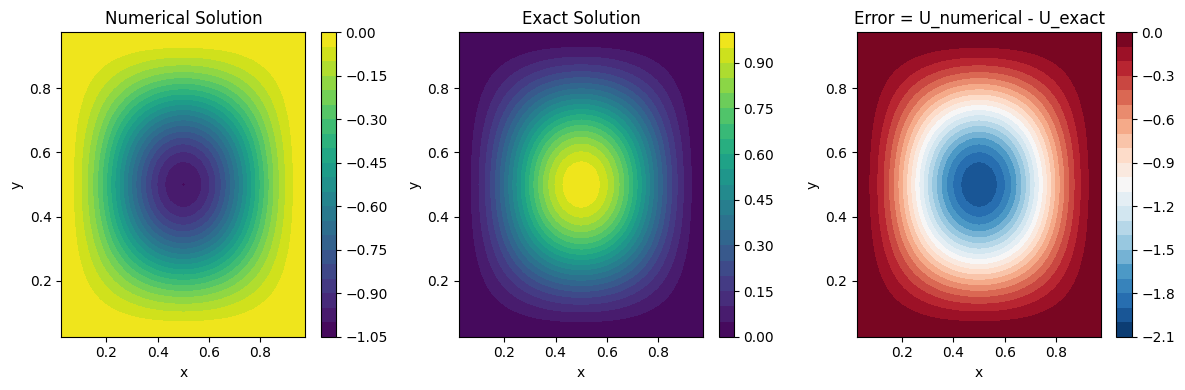

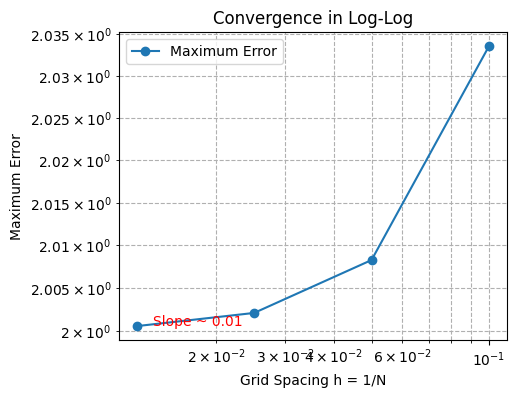

 N h=1/N Maximum Error
10   0.10000  2.033558e+00
20   0.05000  2.008265e+00
40   0.02500  2.002059e+00
80   0.01250  2.000514e+00
Estimated order of Convergence = 0.01


In [10]:
if __name__ == "__main__":
    
    # Choose grid size (Bigger grid size will give more accurate result, but takes more time to run) So thats why I am choosing 40x40 grid.
    Nx, Ny = 40, 40

    # Solve using the 5-point FD scheme
    U_numerical = solve_poisson_eqn(Nx, Ny, f_source)

    # Generate the interior grid for plotting
    x_vals, y_vals, dx, dy = interior_grid_generation(Nx, Ny)
    X, Y = np.meshgrid(x_vals, y_vals)

    # Evaluate exact solution on interior
    U_exact = U_exactact_soln(X, Y)

    # Error
    U_error = U_numerical - U_exact

    # PLOT: Numerical soln, Exact soln, and Error (Difference in the Numerical and Exact solns)
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

    # 1) Numerical solution
    c1 = axes[0].contourf(X, Y, U_numerical, 20, cmap='viridis')
    fig.colorbar(c1, ax=axes[0])
    axes[0].set_title("Numerical Solution")
    axes[0].set_xlabel("x")
    axes[0].set_ylabel("y")

    # 2) Exact solution
    c2 = axes[1].contourf(X, Y, U_exact, 20, cmap='viridis')
    fig.colorbar(c2, ax=axes[1])
    axes[1].set_title("Exact Solution")
    axes[1].set_xlabel("x")
    axes[1].set_ylabel("y")

    # 3) Error
    c3 = axes[2].contourf(X, Y, U_error, 20, cmap='RdBu_r')
    fig.colorbar(c3, ax=axes[2])
    axes[2].set_title("Error = U_numerical - U_exact")
    axes[2].set_xlabel("x")
    axes[2].set_ylabel("y")

    plt.tight_layout()
    plt.show()

    # OPTIONAL: CONVERGENCE STUDY
    # Plot in Log-Log
    grid_list = [10, 20, 40, 80]
    errors = []
    hs = []

    for N in grid_list:
        U_approx = solve_poisson_eqn(N, N, f_source)
        h = 1.0 / N
        hs.append(h)
        
        x_valsN, y_valsN, _, _ = interior_grid_generation(N, N)
        max_e = 0.0
        for j, yj in enumerate(y_valsN):
            for i, xi in enumerate(x_valsN):
                err_ij = abs(U_approx[j, i] - U_exactact_soln(xi, yj))
                if err_ij > max_e:
                    max_e = err_ij
        errors.append(max_e)

    # Plot Maximum Error vs. Grid Spacing h
    plt.figure(figsize=(5,4))
    plt.loglog(hs, errors, 'o-', label='Maximum Error')
    plt.xlabel('Grid Spacing h = 1/N')
    plt.ylabel('Maximum Error')
    plt.title('Convergence in Log-Log')
    plt.grid(True, which='Both', linestyle='--')

    # Estimate slope
    slope = np.polyfit(np.log(hs), np.log(errors), 1)[0]
    plt.text(hs[-1]*1.1, errors[-1], f"Slope ~ {slope:.2f}", color='red')
    plt.legend()
    plt.show()

    # Printing the result of the convergence study
    print(" N h=1/N Maximum Error")
    for N,h,e in zip(grid_list, hs, errors):
        print(f"{N:<3d}  {h:.5f}  {e:.6e}")
    print(f"Estimated order of Convergence = {slope:.2f}")